In [10]:
import numpy as np
import pandas as pd
from scipy.stats import beta, cauchy, gamma, gaussian_kde, expon
import time  # Pour suivre le temps d'exécution
import matplotlib.pyplot as plt

In [11]:
def prior(n, hyper):
    X_1 = beta.rvs(hyper[0], hyper[1] + hyper[2], size=n)
    Temp = beta.rvs(hyper[1], hyper[2], size=n)
    X_2 = Temp * (1 - X_1)
    R_1 = X_1 - X_2
    R_2 = 2 * (X_1 + X_2) - 1
    return np.column_stack((R_1, R_2))

def simu(tht1, tht2, sigm, n):
    A = np.random.normal(0, sigm, size=n + 30)
    U = A[2:(n + 2)]
    V = A[1:(n + 1)]
    W = A[0:n]
    return U + tht1 * V + tht2 * W

def distautcor(Z, X):
    p = len(Z)
    a2 = np.sum(Z[2:p] * Z[0:(p - 2)])
    b2 = np.sum(X[2:p] * X[0:(p - 2)])
    a1 = np.sum(Z[1:p] * Z[0:(p - 1)])
    b1 = np.sum(X[1:p] * X[0:(p - 1)])
    return np.sqrt((a2 - b2)**2 + (a1 - b1)**2)

In [17]:
def ABCbas(X, N, sigm, hyper):
    hyper = np.abs(hyper)
    res = prior(N, hyper)
    dist = np.apply_along_axis(lambda x: distautcor(X - np.mean(X), simu(x[0], x[1], sigm, len(X))), 1, res)
    return res[np.argmin(dist), :]

def statdir(U):
    q = (U[:, 1] + 2 * U[:, 0] + 1) / 4
    q = np.where(q != 0, q, np.finfo(float).eps)  # Remplacer les zéros par une très petite valeur
    
    return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
    
def ABChaut(Q1, Q2, L):
    Q = np.column_stack((Q1, Q2))
    hyper = np.random.exponential(size=(L, 3))
    dist = np.apply_along_axis(lambda x: np.sum((statdir(prior(len(Q1), x)) - statdir(Q))**2), 1, hyper)
    return hyper[np.argmin(dist), :]

def ABCsigm(Dat, j, parh1, parh2, parsigm1, parsigm2, N):
    dist = np.zeros(N)
    n = Dat.shape[0]
    w = np.arange(0, n, 3)
    si = 1 / gamma.rvs(parsigm1, scale=parsigm2, size=N)
    for i in range(N):
        dist[i] = np.abs(np.var(simu(parh1[j], parh2[j], si[i], n)[w]) - np.var(Dat[w, j]))
    return si[np.argmin(dist)]

def ABCsigmhaut(sigm, Q):
    dist = np.zeros(Q)
    n = len(sigm)
    pri = np.abs(cauchy.rvs(size=2*Q)).reshape((Q, 2))
    for i in range(Q):
        h = pri[i]
        
        # Générer une valeur pour h[0] et h[1]
        while True:
            try:
                y = 1 / gamma.rvs(h[0], scale=h[1], size=n)
                break
            except OverflowError:
                # Si une erreur de dépassement de capacité se produit, ajustez les paramètres h[0] et h[1]
                h = np.abs(cauchy.rvs(size=2))
        
        dist[i] = np.abs(np.sum(np.log(y)) - np.sum(np.log(sigm))) + np.abs(np.sum(y) - np.sum(sigm))
    return pri[np.argmin(dist), :]


### Algorithme final Gibbs-ABC

In [18]:
def GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max):
    
    start_time = time.time()
    etapes_realisees = 0 
    hyper = np.zeros((Npts, 3))
    hyper[0, :] = expon.rvs(size=3)
    
    par1 = np.full((Npts, X.shape[1]), np.nan)
    par2 = np.full((Npts, X.shape[1]), np.nan)

    sigm = np.full((Npts, X.shape[1]), np.nan)
    hypersigm = np.full((Npts, 2), np.nan)
    hypersigm[0, :] = np.abs(cauchy.rvs(size=2))
    sigm[0, :] = 1 / gamma.rvs(a=hypersigm[0, 0], scale=hypersigm[0, 1], size=X.shape[1])
    
    d = prior(X.shape[1], hyper[0, :])
    par1[0, :] = d[:, 0]
    par2[0, :] = d[:, 1]

    V = X - np.tile(X.mean(axis=0), (X.shape[0], 1))

    histeps = []  # Liste pour stocker l'historique des epsilons
    eps = float('inf')  # Initialiser epsilon à l'infini

    for i in range(Npts):
        # Vérifier si le temps maximum est dépassé
        current_time = time.time()
        if current_time - start_time > temps_max:
            print(f"Temps maximum d'exécution de {temps_max} secondes atteint à la {i}ème itération.")
            break  # Sortir de la boucle principale si le temps maximum est atteint
        
        dist_i = []
        
        for j in range(X.shape[1]):
            U = ABCbas(X[:, j], N, sigm[i - 1, :], hyper[i - 1, :])
            par1[i, j] = U[0]
            par2[i, j] = U[1]
            sigm[i, j] = ABCsigm(X[:, j], par1[i, :], par2[i, :], hypersigm[i - 1, 0], hypersigm[i - 1, 1], P)
            
            dist = np.abs(np.var(simu_j) - np.var(X[:, j]))
            dist_i.append(dist)

        hyper[i, :] = ABChaut(par1[i, :], par2[i, :], M)
        hypersigm[i, :] = ABCsigmhaut(sigm[i, :], P2)

        eps = min(eps, max(dist_i))  # Mettre à jour epsilon avec la distance maximale de cette itération si elle est plus petite
        histeps.append(eps)  # Ajouter la valeur actuelle d'epsilon à l'historique
        if eps <= objectifeps:  # Vérifier si l'objectif est atteint
            print(f"Objectif epsilon atteint : {eps} <= {objectifeps}")
            break  # Sortir de la boucle si l'objectif est atteint
    
    # Supprimer les lignes remplies de nan ou de 0 
    par1 = par1[~np.isnan(par1).all(axis=1)]
    par2 = par2[~np.isnan(par2).all(axis=1)]
    hyper = hyper[~(np.isnan(hyper).all(axis=1) | np.all(hyper == 0, axis=1))]
    hypersigm = hypersigm[~np.isnan(hypersigm).all(axis=1)]

    resultats = {
        "Paramètre_1": par1,
        "Paramètre_2":par2,
        'Hyperparamètres': hyper,
        'Hypersigma': hypersigm,
        'Historique des epsilons': histeps
    }

    for titre, valeur in resultats.items():
        print(f"{titre}:")
        print(valeur)
        print("\n")  

    return resultats  # Retourne le dictionnaire de résultats

### Calcul des distances entre les valeurs réelles et les valeurs simulées

In [19]:
def distance(resultats, par1_real, par2_real, hyper_real, hypersigm_real, l):

    par1_real=np.full(l, par1_real)
    par2_real=np.full(l, par2_real)
    hyper_real=np.array(hyper_real)
    hypersigm_real=np.array(hypersigm_real)

    par1_estime = resultats["Paramètre_1"]
    par2_estime = resultats["Paramètre_2"]
    hyper_estime = resultats["Hyperparamètres"]
    hypersigm_estime = resultats["Hypersigma"]

    dist_eucli_par1= np.sqrt(np.sum((par1_estime - par1_real) ** 2, axis=1))
    dist_eucli_par2= np.sqrt(np.sum((par2_estime - par2_real) ** 2, axis=1))
    dist_eucli_hyper= np.sqrt(np.sum((hyper_estime - hyper_real) ** 2, axis=1))
    dist_eucli_hypersigm= np.sqrt(np.sum((hypersigm_estime - hypersigm_real) ** 2, axis=1))
    
    # Calculer les distances euclidiennes
    distance_par1 = np.mean(dist_eucli_par1)
    distance_par2= np.mean(dist_eucli_par2)
    distance_hyper = np.mean(dist_eucli_hyper)
    distance_hypersigm = np.mean(dist_eucli_hypersigm)

    # Retourner les distances dans un dictionnaire
    return {
        'Distance Paramètre 1': distance_par1,
        'Distance Paramètre 2': distance_par2,
        'Distance Hyperparamètre': distance_hyper,
        'Distance Hypersigma': distance_hypersigm
    }


### Tests 

In [20]:
l=50
X = np.random.normal(-5, 1, (20, l)) #data
N=1000 #nombre d'échantillons générés pour chaque simulation individuelle de l'algorithme 
P=100 #nombre de simulations pour sigma
P2=100 #nombre de simulations pour l'hypersigma
M=100 #nombre de simulations pour l'hyperparamètre
Npts=1000 #nombre total d'itérations de l'algorithme global
objectifeps=0.1
hyper_real= [1,2,3]
hypersigm_real= [1,1]
par1_real=1
par2_real=1
temps_max=10

In [21]:
resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max)

ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.beta` documentation for details.

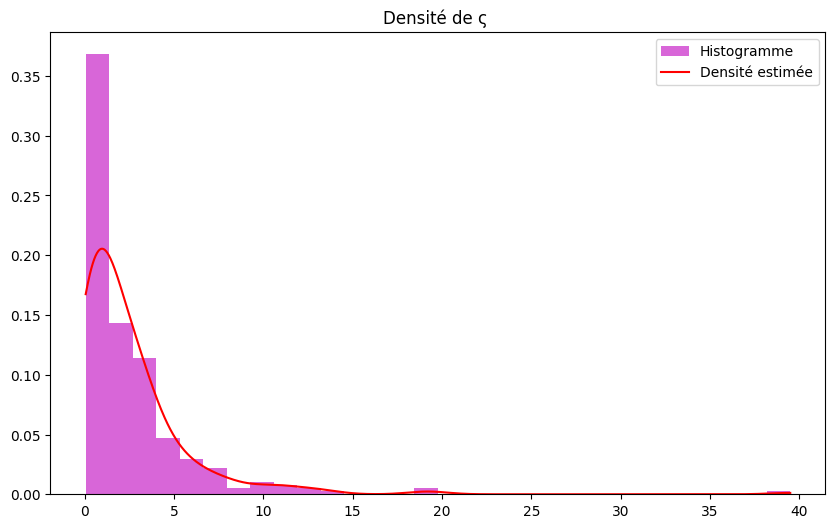

In [ ]:
# Extraction et aplatissement de hypersigma
hypersigm = resultats["Hypersigma"]
hypersigm_flat = hypersigm.flatten()

# Estimation de la densité de probabilité
density_hypersigm = gaussian_kde(hypersigm_flat)
x_vals_hypersigm = np.linspace(min(hypersigm_flat), max(hypersigm_flat), 1000)
density_vals_hypersigm = density_hypersigm(x_vals_hypersigm)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(hypersigm_flat, bins=30, density=True, alpha=0.6, color='m', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals_hypersigm, density_vals_hypersigm, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de ς ')
plt.legend()

# Afficher le graphique
plt.show()

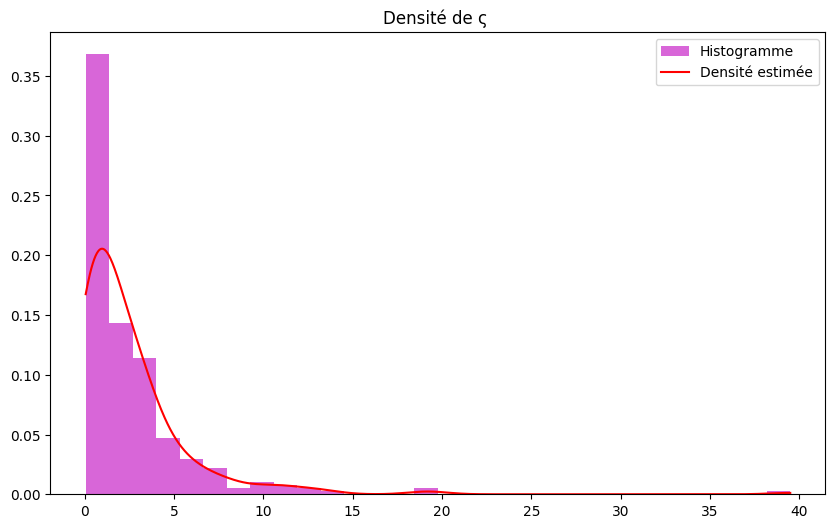

In [ ]:
# Extraction et aplatissement de hypersigma
hypersigm = resultats["Hypersigma"]
hypersigm_flat = hypersigm.flatten()

# Estimation de la densité de probabilité
density_hypersigm = gaussian_kde(hypersigm_flat)
x_vals_hypersigm = np.linspace(min(hypersigm_flat), max(hypersigm_flat), 1000)
density_vals_hypersigm = density_hypersigm(x_vals_hypersigm)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(hypersigm_flat, bins=30, density=True, alpha=0.6, color='m', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals_hypersigm, density_vals_hypersigm, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de ς ')
plt.legend()

# Afficher le graphique
plt.show()

In [62]:
distance(resultats, par1_real, par2_real, hyper_real, hypersigm_real, l)

{'Distance Paramètre 1': 7.2852988717049145,
 'Distance Paramètre 2': 7.945870628800211,
 'Distance Hyperparamètre': 2.235079914416804,
 'Distance Hypersigma': 25.919065029261542}

### Graphes des densités des paramètres estimés

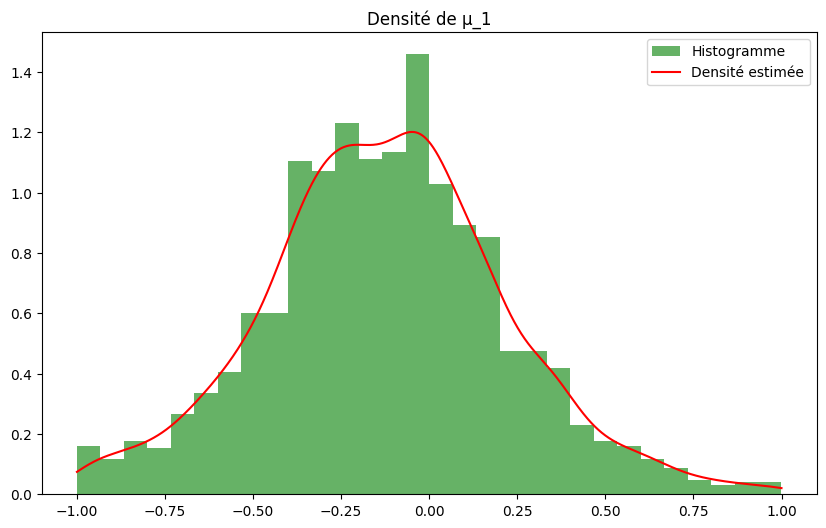

In [77]:
# Extraction et aplatissement du paramètre par1
par1 = resultats["Paramètre_1"]
par1_flat = par1.flatten()

# Estimation de la densité de probabilité
density_par1 = gaussian_kde(par1_flat)
x_vals = np.linspace(min(par1_flat), max(par1_flat), 1000)  # Générer 1000 points entre le min et le max de par1_flat
density_vals_par1 = density_par1(x_vals)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(par1_flat, bins=30, density=True, alpha=0.6, color='g', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals, density_vals_par1, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de µ_1')
plt.legend()

# Afficher le graphique
plt.show()

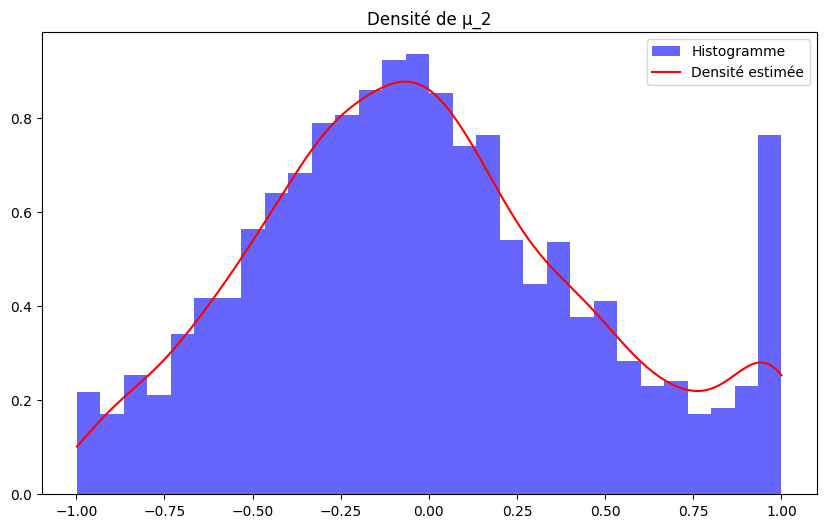

In [78]:
# Extraction et aplatissement du paramètre par2
par2 = resultats["Paramètre_2"]
par2_flat = par2.flatten()

# Estimation de la densité de probabilité
density_par2 = gaussian_kde(par2_flat)
x_vals_par2 = np.linspace(min(par2_flat), max(par2_flat), 1000)
density_vals_par2 = density_par2(x_vals_par2)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(par2_flat, bins=30, density=True, alpha=0.6, color='b', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals_par2, density_vals_par2, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de µ_2')
plt.legend()

# Afficher le graphique
plt.show()

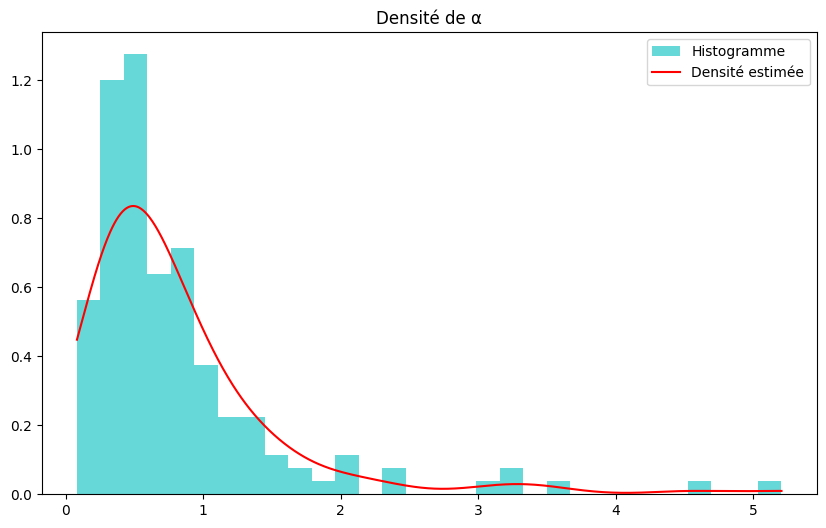

In [79]:
# Extraction et aplatissement des hyperparamètres
hyper = resultats["Hyperparamètres"]
hyper_flat = hyper.flatten()

# Estimation de la densité de probabilité
density_hyper = gaussian_kde(hyper_flat)
x_vals_hyper = np.linspace(min(hyper_flat), max(hyper_flat), 1000)
density_vals_hyper = density_hyper(x_vals_hyper)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(hyper_flat, bins=30, density=True, alpha=0.6, color='c', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals_hyper, density_vals_hyper, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de α')
plt.legend()

# Afficher le graphique
plt.show()

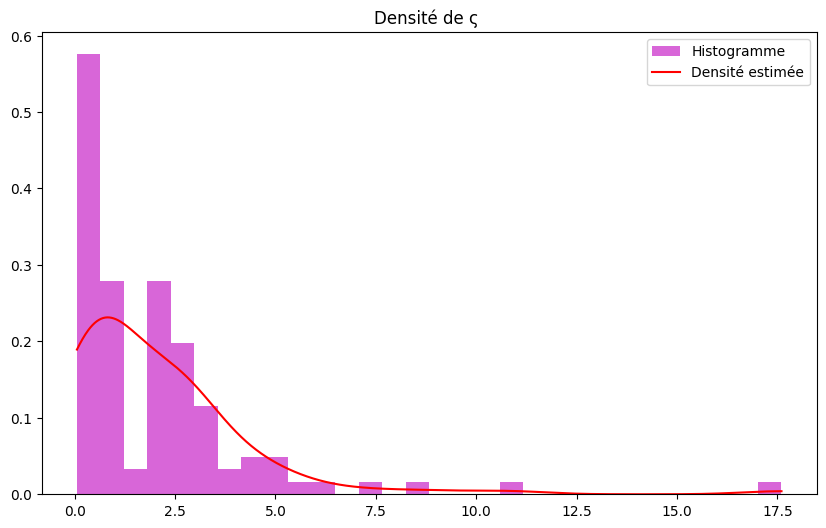

In [80]:
# Extraction et aplatissement de hypersigma
hypersigm = resultats["Hypersigma"]
hypersigm_flat = hypersigm.flatten()

# Estimation de la densité de probabilité
density_hypersigm = gaussian_kde(hypersigm_flat)
x_vals_hypersigm = np.linspace(min(hypersigm_flat), max(hypersigm_flat), 1000)
density_vals_hypersigm = density_hypersigm(x_vals_hypersigm)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(hypersigm_flat, bins=30, density=True, alpha=0.6, color='m', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals_hypersigm, density_vals_hypersigm, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de ς ')
plt.legend()

# Afficher le graphique
plt.show()

### Analyse de sensibilité et de performance 

C:\Users\sarah\AppData\Local\Temp\ipykernel_24660\3082693489.py:10: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_24660\3082693489.py:37: RuntimeWarning: divide by zero encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=n)
C:\Users\sarah\AppData\Local\Temp\ipykernel_24660\3082693489.py:37: RuntimeWarning: overflow encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=n)


Temps maximum d'exécution de 30 secondes atteint à l'étape 17.
Paramètre_1:
[[-7.58735898e-02  1.56615079e-01  6.54447209e-02 -9.17916972e-02
   8.94523032e-03  8.62478602e-02  1.14253727e-01 -6.74508319e-02
   5.91348324e-02 -1.29371979e-01 -4.14839019e-02 -1.32768718e-01
   3.84077444e-01  1.09240374e-01  9.22275201e-02 -1.58710403e-01
   4.33903322e-01  1.84670220e-01  1.41374480e-01  1.16721135e-01
   1.43233373e-01  3.87037353e-01  1.02712912e-01  5.48948319e-02
   3.21895268e-01  3.95893485e-03  6.51057647e-01  2.61234496e-03
   8.41110435e-02  3.61343302e-02 -5.25338749e-02  2.52245177e-01
   1.46769862e-01  3.15273070e-01 -2.12491516e-02  1.37072097e-01
  -1.37451516e-02  1.44972848e-01  1.32632180e-01 -3.66502812e-02
   2.54297692e-01 -2.10944928e-01  5.38897818e-02  1.35568129e-01
   2.05945639e-01  4.65041340e-02  1.62694914e-02 -2.79152996e-02
   4.39460521e-02  1.77607163e-01]
 [ 8.64331476e-02  2.07747948e-02 -3.81438871e-03  6.72796394e-02
   3.18523805e-03  1.43693561e-

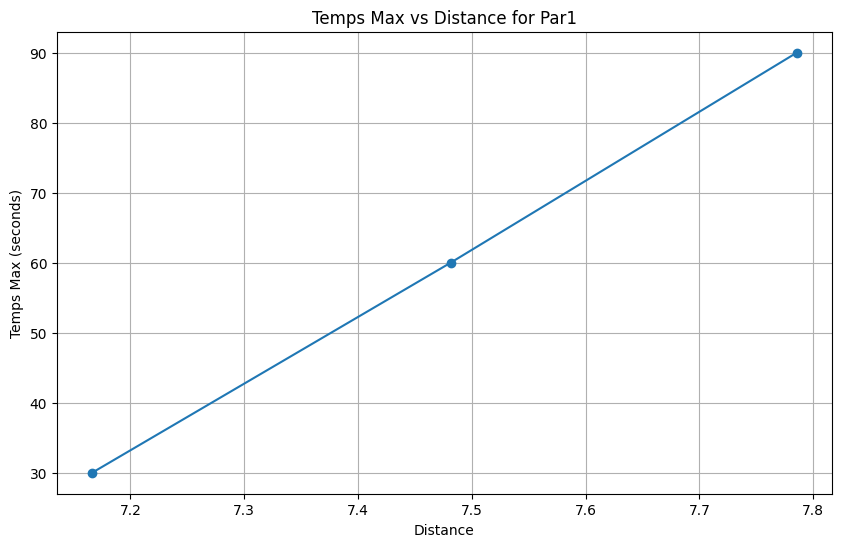

In [69]:
temps_max_values = range(30, 120, 30) 
standard_error_hyper = []
standard_error_hypersigma = []
distance_par1 = []
distance_hyper = []
distance_hypersigm = []

for temps_max in temps_max_values:
    resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max)
    hyper = resultats["Hyperparamètres"]
    hypersigma=resultats["Hypersigma"]
    std_hyper = np.std(hyper, axis=0)
    std_hypersigma = np.std(hypersigma, axis=0)
    standard_error_hyper.append(standard_error_hyper)
    standard_error_hypersigma.append(standard_error_hypersigma)

    dist = distance(resultats, par1_real, par2_real, hyper_real, hypersigm_real,l)
    dist_par1=dist['Distance Paramètre 1']
    dist_hyper=dist['Distance Hyperparamètre']
    dist_hypersigm=dist['Distance Hypersigma']
    distance_par1.append(dist_par1)
    distance_hyper.append(dist_hyper)
    distance_hypersigm.append(dist_hypersigm)


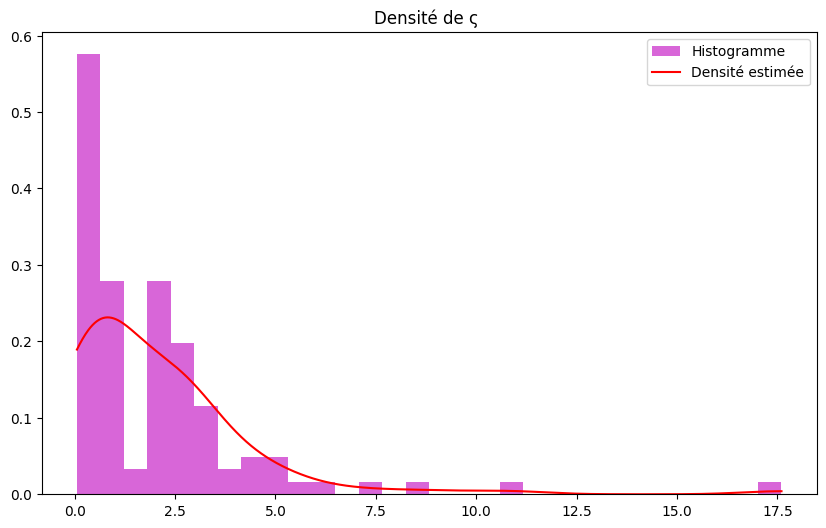

In [ ]:
# Extraction et aplatissement de hypersigma
hypersigm = resultats["Hypersigma"]
hypersigm_flat = hypersigm.flatten()

# Estimation de la densité de probabilité
density_hypersigm = gaussian_kde(hypersigm_flat)
x_vals_hypersigm = np.linspace(min(hypersigm_flat), max(hypersigm_flat), 1000)
density_vals_hypersigm = density_hypersigm(x_vals_hypersigm)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(hypersigm_flat, bins=30, density=True, alpha=0.6, color='m', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals_hypersigm, density_vals_hypersigm, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de ς ')
plt.legend()

# Afficher le graphique
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(distance_par1, temps_max_values, marker='o', linestyle='-')
plt.title('Temps Max vs Distance for Par1')
plt.xlabel('Distance')
plt.ylabel('Temps Max (secondes)')
plt.grid(True)
plt.show()

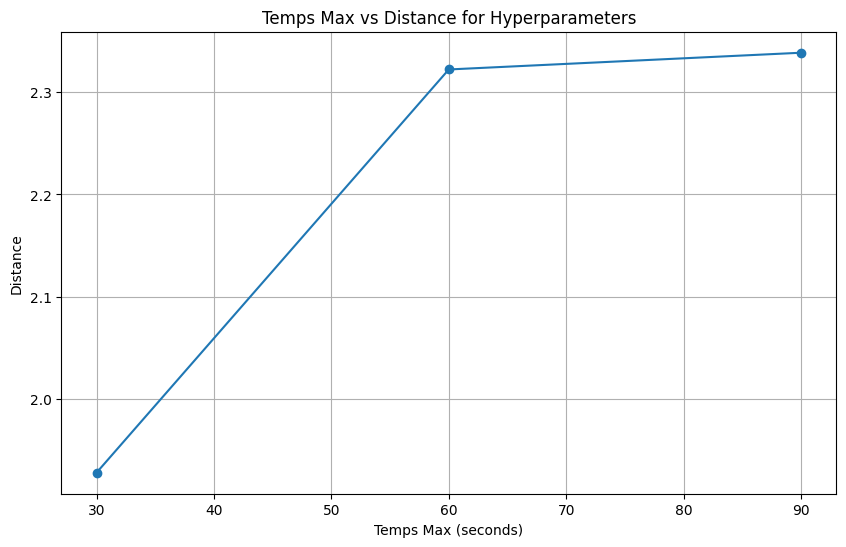

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, distance_hyper,  marker='o', linestyle='-')
plt.title('Temps Max vs Distance for Hyperparameters')
plt.ylabel('Distance')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()

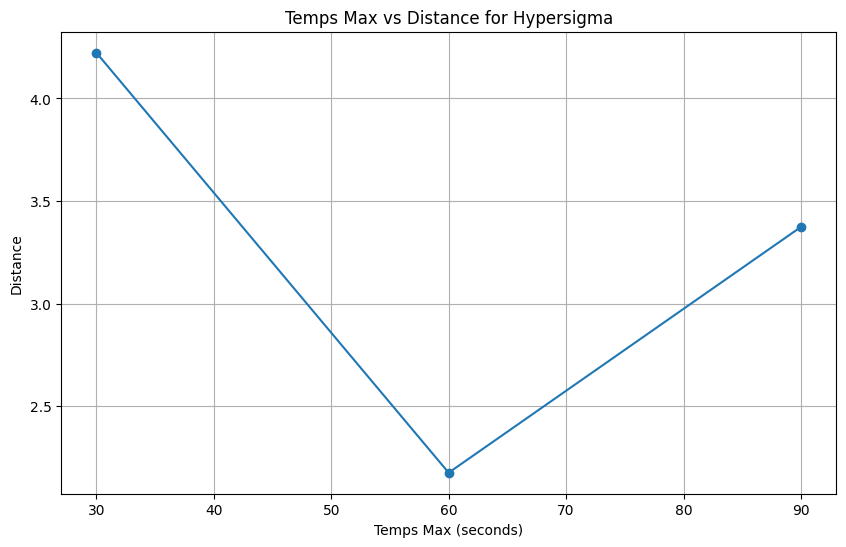

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, distance_hypersigm, marker='o', linestyle='-')
plt.title('Temps Max vs Distance for Hypersigma')
plt.ylabel('Distance')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()